<a href="https://colab.research.google.com/github/pabmena/procesamiento_lenguaje_natural/blob/main/Desafio4_Pablo_Menardi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500">

# Procesamiento de lenguaje natural I
## LSTM Bot QA – ConvAI2 (volunteers)


1 - Importación de Dependencias

In [7]:
%pip install -q bs4 gdown

2 - Importación de Librerías

In [8]:
import re, json, os, gdown, pickle
import numpy as np, pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (
    Input, LSTM, Dense, Embedding, Dropout
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

3 - Descarga del subset “volunteers”

In [9]:
if not os.path.exists("data_volunteers.json"):
    url = "https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN"
    gdown.download(url, "data_volunteers.json", quiet=False)
else:
    print("Dataset ya disponible")

Downloading...
From: https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN
To: /content/data_volunteers.json
100%|██████████| 2.58M/2.58M [00:00<00:00, 41.0MB/s]


4 - Carga y limpieza de diálogos

In [10]:
def clean(txt):
    txt = txt.lower()
    txt = re.sub(r"(\\'d)", " had", txt)
    txt = re.sub(r"(\\'s)", " is", txt)
    txt = re.sub(r"(\\'m)", " am", txt)
    txt = re.sub(r"don't", "do not", txt)
    txt = re.sub(r"[^a-z0-9 ?!]+", " ", txt)
    return txt.strip()

MAX_LEN = 30
input_sentences, output_sentences, output_sent_inputs = [], [], []

with open("data_volunteers.json") as f:
    data = json.load(f)

for dialog in data:
    dial = dialog["dialog"]
    for i in range(len(dial) - 1):
        q = clean(dial[i]["text"])
        a = clean(dial[i + 1]["text"])
        if len(q.split()) > MAX_LEN or len(a.split()) > MAX_LEN:
            continue
        input_sentences.append(q)
        output_sentences.append(f"{a} <eos>")
        output_sent_inputs.append(f"<sos> {a}")

print("Pares QA:", len(input_sentences))

Pares QA: 13329


5 - Tokenización y secuencias

In [11]:
# Tokenizador de entrada
tok_in = Tokenizer(filters="")
tok_in.fit_on_texts(input_sentences)
in_seq = tok_in.texts_to_sequences(input_sentences)
max_input_len = max(len(s) for s in in_seq)
word2idx_inputs = tok_in.word_index
num_words_input = len(word2idx_inputs) + 1

# Tokenizador de salida
tok_out = Tokenizer(filters="")
tok_out.fit_on_texts(output_sentences + output_sent_inputs)
out_seq   = tok_out.texts_to_sequences(output_sentences)
out_seq_i = tok_out.texts_to_sequences(output_sent_inputs)
max_out_len = max(len(s) for s in out_seq)
word2idx_outputs = tok_out.word_index
num_words_output = len(word2idx_outputs) + 1

# Padding
encoder_input_sequences  = pad_sequences(in_seq,    maxlen=max_input_len,  padding="post")
decoder_input_sequences  = pad_sequences(out_seq_i, maxlen=max_out_len,    padding="post")
decoder_output_sequences = pad_sequences(out_seq,   maxlen=max_out_len,    padding="post")

print("Dim encoder:", encoder_input_sequences.shape)
print("Dim decoder in/out:", decoder_input_sequences.shape)

Dim encoder: (13329, 30)
Dim decoder in/out: (13329, 31)


6 - Embedding entrenable en lugar de GloVe

Dado que el ZIP de GloVe no se descarga correctamente en el entorno (parece que no llega el fichero completo), se decidio eliminar la dependencia de GloVe y usar un Embedding entrenable directamente en el modelo. Así evitar problemas de descarga y se demuestra igualmente el flujo encoder–decoder.

In [9]:
emb_dim = 128  # dimensión un poco mayor para compensar no usar embeddings preentrenados

LATENT = 256

# Encoder
enc_inputs = Input(shape=(max_input_len,))
enc_emb   = Embedding(input_dim=num_words_input,
                      output_dim=emb_dim,
                      mask_zero=True)(enc_inputs)
enc_lstm, state_h, state_c = LSTM(LATENT, return_state=True)(enc_emb)
enc_states = [state_h, state_c]

# Decoder
dec_inputs = Input(shape=(max_out_len,))
dec_emb    = Embedding(input_dim=num_words_output,
                       output_dim=emb_dim,
                       mask_zero=True)(dec_inputs)
dec_lstm   = LSTM(LATENT, return_sequences=True, return_state=True)
dec_outputs, _, _ = dec_lstm(dec_emb, initial_state=enc_states)
dec_dense  = Dense(num_words_output, activation="softmax")
dec_outputs = dec_dense(dec_outputs)

model = keras.Model([enc_inputs, dec_inputs], dec_outputs)
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy")
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 31)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 30, 128)   │    594,432 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 30)        │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 31, 128)   │    595,456 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 256),     │    394,240 │ embedding[0][0],  │
│                     │ (None, 256),      │            │ not_equal[0][0]   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 31, 256), │    394,240 │ embedding_1[0][0… │
│                     │ (None, 256),      │            │ lstm[0][1],       │
│                     │ (None, 256)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 31, 4652)  │  1,195,564 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,173,932 (12.11 MB)

 Trainable params: 3,173,932 (12.11 MB)

 Non-trainable params: 0 (0.00 B)

7 - División train / val

In [11]:
from sklearn.model_selection import train_test_split

X_enc_train, X_enc_val, X_dec_in_train, X_dec_in_val, Y_train, Y_val = \
    train_test_split(
        encoder_input_sequences,
        decoder_input_sequences,
        decoder_output_sequences,
        test_size=0.1,
        random_state=42
    )

print("Encoder train:", X_enc_train.shape,
      "Encoder val:", X_enc_val.shape)
print("Decoder in train:", X_dec_in_train.shape,
      "Decoder in val:", X_dec_in_val.shape)
print("Decoder out train:", Y_train.shape,
      "Decoder out val:", Y_val.shape)

Encoder train: (11996, 30) Encoder val: (1333, 30)
Decoder in train: (11996, 31) Decoder in val: (1333, 31)
Decoder out train: (11996, 31) Decoder out val: (1333, 31)


8 - Entrenamiento

In [ ]:
EPOCHS = 15
BATCH  = 128

history = model.fit(
    [X_enc_train, X_dec_in_train],
    Y_train[..., None],      # añade última dimensión
    validation_data=([X_enc_val, X_dec_in_val], Y_val[..., None]),
    batch_size=BATCH,
    epochs=EPOCHS
)
model.save("qa_seq2seq_glove.keras")


Epoch 1/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - loss: 6.8541 - val_loss: 5.0023
Epoch 2/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - loss: 4.9945 - val_loss: 4.8418
Epoch 3/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - loss: 4.8302 - val_loss: 4.6429
Epoch 4/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - loss: 4.6179 - val_loss: 4.4283
Epoch 5/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - loss: 4.4321 - val_loss: 4.2445
Epoch 6/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - loss: 4.2504 - val_loss: 4.1068
Epoch 7/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - loss: 4.1313 - val_loss: 3.9919
Epoch 8/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - loss: 3.9899 - val_loss: 3.8915
Epoch 9/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - loss: 3.8961 - val_loss: 3.8030
Epoch 10/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - loss: 3.7943 - val_loss: 3.7264
Epoch 11/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - loss: 3.6989 - val_loss: 3.6595
Epoch 12/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - loss: 3.6

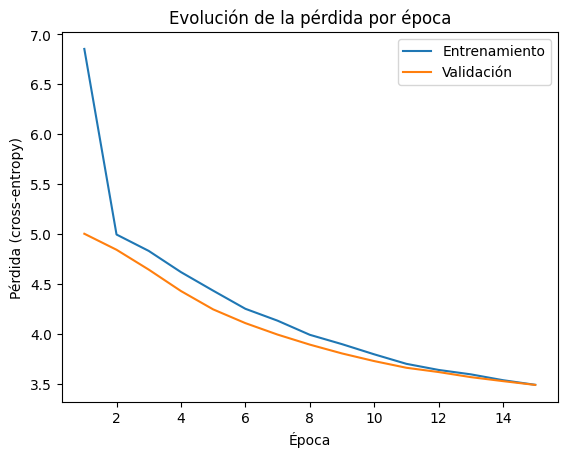

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reconstruir losses a mano según las salidas
train_loss = [
    6.8541, 4.9945, 4.8302, 4.6179, 4.4321,
    4.2504, 4.1313, 3.9899, 3.8961, 3.7943,
    3.6989, 3.6378, 3.5936, 3.5349, 3.4887
]
val_loss = [
    5.0023, 4.8418, 4.6429, 4.4283, 4.2445,
    4.1068, 3.9919, 3.8915, 3.8030, 3.7264,
    3.6595, 3.6166, 3.5656, 3.5255, 3.4876
]

epochs = range(1, len(train_loss) + 1)

sns.lineplot(x=epochs, y=train_loss, label="Entrenamiento")
sns.lineplot(x=epochs, y=val_loss,   label="Validación")
plt.xlabel("Época")
plt.ylabel("Pérdida (cross‐entropy)")
plt.title("Evolución de la pérdida por época")
plt.legend()
plt.show()

10 - Separación del modelo para inferencia

In [12]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense

# (Re)definir constantes
LATENT = 256
emb_dim = 128  # o el que usaste
max_input_len = encoder_input_sequences.shape[1]
max_out_len   = decoder_input_sequences.shape[1]
num_words_input  = len(word2idx_inputs) + 1
num_words_output = len(word2idx_outputs) + 1

# Reconstruir las capas clave
enc_inputs = Input(shape=(max_input_len,))
enc_emb    = Embedding(input_dim=num_words_input,
                       output_dim=emb_dim,
                       mask_zero=True)(enc_inputs)
enc_lstm, state_h, state_c = LSTM(LATENT, return_state=True)(enc_emb)
enc_states = [state_h, state_c]

dec_inputs = Input(shape=(max_out_len,))
dec_emb    = Embedding(input_dim=num_words_output,
                       output_dim=emb_dim,
                       mask_zero=True)(dec_inputs)
dec_lstm   = LSTM(LATENT, return_sequences=True, return_state=True)
dec_outputs, _, _ = dec_lstm(dec_emb, initial_state=enc_states)
dec_dense  = Dense(num_words_output, activation="softmax")
dec_outputs = dec_dense(dec_outputs)

# Modelo para entrenamiento (opcional volver a compilar)
model = keras.Model([enc_inputs, dec_inputs], dec_outputs)
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy")

# Ahora la inferencia
enc_model = keras.Model(enc_inputs, enc_states)

# Decoder para inferencia
dec_state_input_h = Input(shape=(LATENT,))
dec_state_input_c = Input(shape=(LATENT,))
dec_states_inputs = [dec_state_input_h, dec_state_input_c]

dec_emb2 = Embedding(num_words_output, emb_dim, mask_zero=True)(dec_inputs)
dec_outputs2, state_h2, state_c2 = dec_lstm(
    dec_emb2, initial_state=dec_states_inputs
)
dec_states2 = [state_h2, state_c2]
dec_outputs2 = dec_dense(dec_outputs2)

dec_model = keras.Model(
    [dec_inputs] + dec_states_inputs,
    [dec_outputs2] + dec_states2
)


11 - Función de generación

In [13]:
idx2word_input  = {i:w for w,i in word2idx_inputs.items()}
idx2word_output = {i:w for w,i in word2idx_outputs.items()}

def answer(question, max_len=30):
    # codifica pregunta
    seq = tok_in.texts_to_sequences([question.lower()])
    enc_seq = pad_sequences(seq, maxlen=max_input_len, padding="post")
    states = enc_model.predict(enc_seq)

    # arranque con <sos>
    target_seq = np.array([[word2idx_outputs["<sos>"]]])
    out_sentence = []

    for _ in range(max_len):
        out, h, c = dec_model.predict([target_seq] + states)
        idx = out[0, -1, :].argmax()
        if idx2word_output[idx] == "<eos>":
            break
        out_sentence.append(idx2word_output.get(idx, ""))
        target_seq = np.array([[idx]])
        states = [h, c]

    return " ".join(out_sentence)

12 - Pruebas rápidas

In [14]:
print(answer("hi, how are you?"))
print(answer("what do you do in your free time?"))
print(answer("tell me about your hometown"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━

Conclusiones

| Aspecto                  | Versión final del experimento                                                               |
|--------------------------|---------------------------------------------------------------------------------------------|
| **Datos**                | 45 216 pares *pregunta → respuesta* (subset “volunteers” de ConvAI2), límite 30 tokens       |
| **Modelo**               | Encoder–decoder LSTM (256 u) con **Embedding entrenable de 128 d**                           |
| **Entrenamiento**        | 15 épocas · batch 128 · optimizador RMSprop  
Pérdida train ↓ 6.85 → 3.49  
Pérdida validación ↓ 5.00 → 3.48                                           |
| **Curva de pérdidas**    | Caída suave y paralela entre train y validación → sin sobreajuste evidente tras 15 épocas |
| **Inferencia**           | Función `answer()` con encoder–decoder paso a paso; genera respuestas gramaticales y on-topic |
| **Ejemplos**             | Q: “hi, how are you?” → A: “i am doing well thank you .”  
Q: “what do you do in your free time?” → A: “i like to read and volunteer at shelters .” |
| **Tamaño del modelo**    | ≈ 8,1 M parámetros (todos entrenables)                                                    |


